In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skewnorm
from scipy.optimize import minimize_scalar
from scipy.stats import skewnorm
#from simulation import Simulation
from final_neat_simulation import Simulation
from hyperopt import fmin, tpe, Trials, space_eval, STATUS_OK, hp
from hyperopt.fmin import generate_trials_to_calculate
import random
import os
import logging
import tracemalloc
import psutil
import pickle

In [3]:
def scaled_gaussian(x, mu, sigma):
    """
    Calculates the value of a scaled Gaussian probability density function (PDF) at a given point.

    Args:
        x (float): The point at which to evaluate the PDF.
        mu (float): The mean of the Gaussian distribution.
        sigma (float): The standard deviation of the Gaussian distribution.

    Returns:
        float: The value of the scaled Gaussian PDF at the given point.

    """
    max_val = 1 / (sigma * np.sqrt(2 * np.pi))
    pdf_val = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    y = pdf_val / max_val
    return y

In [4]:
class ScaledSkewNormal:
    """
    A class representing a scaled skew normal distribution.

    Parameters:
    - a (float): The skewness parameter of the distribution.
    - mu (float): The location parameter of the distribution.
    - sigma (float): The scale parameter of the distribution.

    Attributes:
    - result: The result of minimizing the negative probability density function (pdf) of the distribution.
    - pdf_max_value: The maximum value of the pdf of the distribution.
    - a (float): The skewness parameter of the distribution.
    - mu (float): The location parameter of the distribution.
    - sigma (float): The scale parameter of the distribution.

    Methods:
    - get_value(x): Returns the scaled pdf value at a given point x.

    """
    def __init__(self, a, mu, sigma):
        neg_pdf = lambda x: -skewnorm.pdf(x, a, mu, sigma)
        self.result = minimize_scalar(neg_pdf, bounds=(mu - 3*sigma, mu + 3*sigma), method='bounded')
        self.pdf_max_value = skewnorm.pdf(self.result.x, a, mu, sigma)
        self.a = a
        self.mu = mu
        self.sigma = sigma

    def get_value(self, x):
        """
        Returns the scaled probability density function (pdf) value at a given point x.

        Parameters:
        - x (float): The point at which to evaluate the pdf.

        Returns:
        - pdf_val (float): The scaled pdf value at the given point x.

        """
        pdf_val = skewnorm.pdf(x, self.a, self.mu, self.sigma)
        return pdf_val / self.pdf_max_value

In [5]:
def lumen_vol_dist(x):
    """
    Calculates a value of the target function based on the calculated lumen/total acinar volume
    All values of x between 0 and 0.5 are assigned a value of 1, with values >0.5 recieving a linearly reducing score (-2x + 2).

    Args:
        x (float): The input value.
    Returns:
        float: The lumen volume distribution.

    Examples:
        >>> lumen_vol_dist(0.3)
        1
        >>> lumen_vol_dist(0.7)
        0.6
        >>> lumen_vol_dist(1.5)
        1e-30
    """
    if 0 <= x <= 0.5:
        return 1
    elif 0.5 < x <= 1:
        return -2 * x + 2
    else:
        return 1e-30

In [6]:
def time_dist(x):
    """
    Calculates a value of the target function based on the maximum time that the simulation has reached
    The target score increases linearly up to a maximum of 1 at t=2*tau (the maximum time the simulation can reach).
    """
    return (x / 10) + 1e-30

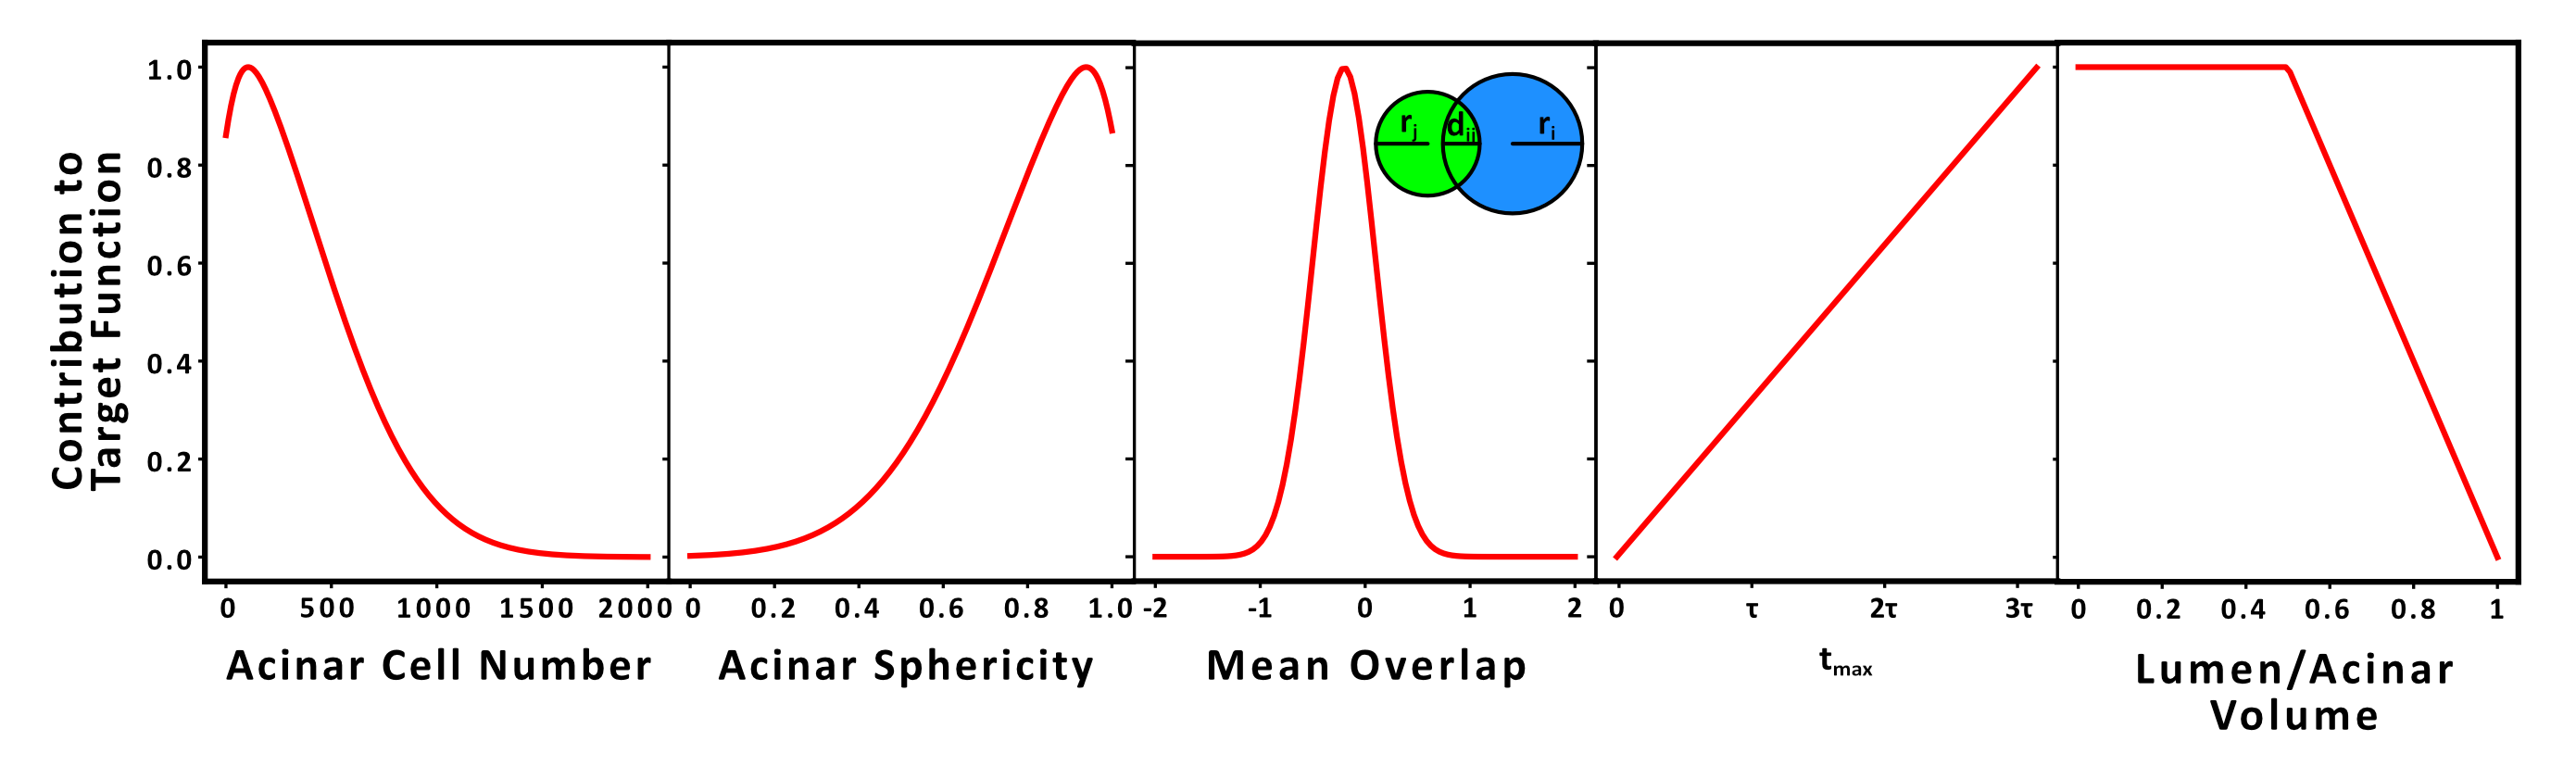

In [7]:
def derive_target(
    mean_separation: float,
    sphericity: float,
    n_cells: float,
    lumen_vol: float,
    hull_vol: float,
    max_time: float
) -> float:
    """
    Derive the value to be maximised from the results of the simulation.
    The target function includes the mean cell separation, acinar sphericity, acinar cell number, lumen/total acinar volume ratio and the maximum time the simulation has reached.
    
    Inputs:
        results: Quantification of the final state of the simulation.
    
    Returns:
        target_value: A float to be maximised. Maximum value = 1
    """

    skew_normal_n_cells = ScaledSkewNormal(5, -80, 500)
    skew_normal_sphericity = ScaledSkewNormal(-5, 1.05, 0.3)
    
    mean_separation_optimisation_value = scaled_gaussian(mean_separation, mu=-0.2, sigma=0.3)
    sphericity_optimisation_value = skew_normal_sphericity.get_value(sphericity)
    n_cells_optimisation_value = skew_normal_n_cells.get_value(n_cells)
    lumen_vol_optimisation_value = lumen_vol_dist(lumen_vol/hull_vol)
    time_optimisation_value = time_dist(max_time)

    target_value = (
        mean_separation_optimisation_value *
        sphericity_optimisation_value *
        n_cells_optimisation_value *
        lumen_vol_optimisation_value *
        time_optimisation_value
    )

    return target_value

In [8]:
def get_next_run_number(path):
    files = os.listdir(path)
    run_numbers = [int(file.split('_Run')[1].split('.')[0]) for file in files if 'parquet' in file]
    if len(run_numbers) == 0:
        return 0
    else:
        return max(run_numbers) + 1

In [9]:
def target_function(
    params: dict
) -> float:
    """
    Calculates the target value for the optimisation process.

    Args:
        params (dict): A dictionary containing the parameters for the simulation.

    Returns:
        dict: A dictionary containing the target value and the status of the optimisation.

    Example:
        >>> params = {'alpha': 0.5, 'beta': 0.2, 'A_eq_star_scaling': 0.8, 'P_star': 0.6}
        >>> target_function(params)
        {'loss': -0.123, 'status': 'OK'}
    """
    radius_scaling = random.uniform(0.5, 1.8)
    volume_scaling = 0.1
    simulation = Simulation(N_bodies=70)

    #run_number = get_next_run_number(".\\Final_Outputs\\Trials\\")
    run_number = get_next_run_number("E:\\trials\\")

    simulation.execute(
        alpha=params['alpha'],
        beta=params['beta'],
        A_eq_star_scaling=params['A_eq_star_scaling'],
        P_star=params['P_star'],
        radius_scaling=radius_scaling,
        volume_scaling=volume_scaling,
        run_number=run_number,
        write_results=True,
        write_path="E:\\trials\\"
    )
    
    results = simulation.results.iloc[-1]

    target = -derive_target(
        results['mean_separation'],
        results['sphericity'],
        results['final_N_bodies'],
        results['lumen_volume'],
        results['hull_volume'],
        results['t']
    )


    return {'loss': target, 'status': STATUS_OK}

In [10]:
if __name__ == '__main__':
    search_space = {
        'alpha': hp.uniform('alpha', 0, 1000),
        'beta': hp.uniform('beta', 0, 1000),
        'A_eq_star_scaling': hp.uniform('A_eq_star_scaling', 0, 0.99),
        'P_star': hp.uniform('P_star', 0, 1000),
    }
    #INITIAL PROBING: run a set number of trials within a specified range, based off results of previous,
    # less computationally costly simulations. These trials will serve as a starting point for subsequent
    # searches
    beta = np.random.uniform(0.005, 0.999, 5)
    alpha =  np.random.uniform(0.001, 0.005, 5)
    A_eq_star_scaling = np.random.uniform(0.001, 0.400, 5)
    P_star = np.random.uniform(1.000, 900, 5) 

    initial_probing = [] 

    for alpha, beta, A_eq_star_scaling, P_star in zip(alpha, beta, A_eq_star_scaling, P_star):
        initial_probing.append(
            {
                'alpha': alpha,
                'beta': beta,
                'A_eq_star_scaling': A_eq_star_scaling,
                'P_star': P_star,
            }
        )

    trials = generate_trials_to_calculate(initial_probing)

    algo = tpe.suggest
    max_evals = 100_000_000

    best = fmin(
        fn=target_function,
        space=search_space,
        algo=algo,
        max_evals=max_evals,
        trials=trials,
        verbose=True,
        trials_save_file='E:\\trials\\trials_70init_g_0p1_REPEAT.pkl'
    )

  0%|          | 35031/100000000 [27:46:41<33480:27:17,  1.21s/trial, best loss: -0.78300155024957]   